In [ ]:
!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" --header "Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/57364%2F110433%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1596444262&Signature=K1BYbE%2B4tSN1AVXTBUzrhopSGhNvmgdSmLabk7e5jVmmYyrFoVqT0s6JGSUa2cGiF7taa4djxQWjlBYq4Icg3v4oNfjGREE0MAXzKaF6CsxP2W5KksjwqRHLHiH3rGKZ1wVBgXQ3I3%2Fn8bZ%2FQMpnVRW3xuyZ9M6uHAqngS8HDdIl%2FcI2GYQN55HoFfz7EbQc2p3VBGz4lP%2BG6ST8NUlobUjJE9BtYX4Q2gwQb1%2Ba2Kw5Q7J6wbvPsa2e9i96DmV3KIPamA4fPS2Mtk%2Frw91NNv7zI6D1QSsGEpgCmXZwC5Sej8fNbxIxjQGkRUkvZZALG%2BswfGE5BPFQ6fhbkPAzFA%3D%3D" -L -o 'omniglot.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.0M  100 30.0M    0     0  62.9M      0 --:--:-- --:--:-- --:--:-- 62.8M


In [ ]:
!unzip omniglot.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

import matplotlib.pyplot as plt



import PIL

import glob
import os

from collections import defaultdict
import random
import numpy as np


    

In [ ]:
def save_model(save_path, model, optimizer, val_loss):
  state_dict = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'val_loss': val_loss
  }
  torch.save(state_dict, save_path)
  print(f'model saved to {save_path}')

def load_model(load_path, model, optimizer):
  state_dict = torch.load(load_path)
  model.load_state_dict(state_dict['model'])
  optimizer.load_state_dict(state_dict['optimizer'])
  print(f'Model loaded from {load_path}')
  return state_dict['val_loss']

In [ ]:
train_dir = 'images_background/'
#train_dict = read_files(train_dir)

# test_dir = 'data/omniglot/images_evaluation/'
# test_dict = read_files(test_dir)

In [ ]:
img_transform = transforms.Compose([
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),])

In [ ]:
class TestData(Dataset):
  def __init__(self, data_path, data_size, n_ways, transforms=None):
    super(TestData, self).__init__()
    self.data_size = data_size
    self.data_path = data_path
    self.n_ways = n_ways
    self.transforms = transforms
    self.data_dict = self.read_files()

  def read_files(self):
      work_dir = os.getcwd()
      os.chdir(self.data_path)
      data_dict = defaultdict(dict)

      try:
          for file in glob.glob('./*/*'):
              path_split = file.split('/')[1:]
              data_dict[path_split[0]][path_split[1]] = os.listdir(file)
      except Exception as e:
          print(e)
          os.chdir(work_dir)
      os.chdir(work_dir)

      return data_dict
    
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, index):
    test_set = []
    target_cat = random.choice(list(self.data_dict.keys()))
    target_char = random.choice(list(self.data_dict[target_cat].keys()))
    main_img = random.choice(self.data_dict[target_cat][target_char])
    main_img = '/'.join([target_cat, target_char, main_img])

    label = random.randint(0, self.n_ways-1)
    for i in range(self.n_ways):
      if i == label:
        img = random.choice(list(set(self.data_dict[target_cat][target_char])-set(main_img)))
        img = '/'.join([target_cat, target_char, img])
        test_set.append(img)
        continue
      
      if random.random() > 0.3:
        char = random.choice(list(set(self.data_dict[target_cat].keys())-set([target_char])))
        img =  random.choice(self.data_dict[target_cat][char])
        img = '/'.join([target_cat, char, img])
        test_set.append(img)
      else:
        cat = random.choice(list(set(self.data_dict.keys())-set([target_cat])))
        char = random.choice(list(self.data_dict[cat].keys()))
        img = random.choice(self.data_dict[cat][char])
        img = '/'.join([cat, char, img])
        test_set.append(img)
    if self.transforms:
      main_img = self.transforms(PIL.Image.open(self.data_path + '/' + main_img))
      test_set = [self.transforms(PIL.Image.open(self.data_path + '/' + img)) for img in test_set]
      test_set = torch.stack(test_set)
    return (main_img, test_set, torch.tensor([label], dtype=torch.float))

      

      
      


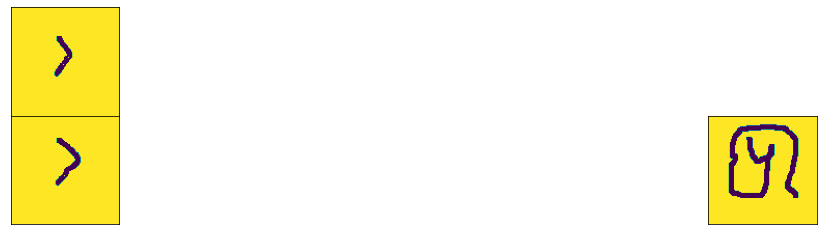

In [ ]:
main_img, test_set, label = next(iter(test_loader))
fig = plt.figure(figsize=(25,4))
test_set = test_set.squeeze(0)
num_test = test_set.shape[0]

ax1 = fig.add_subplot(2,num_test,label.item()+1, xticks=[], yticks=[])
img = main_img.numpy().squeeze(0).squeeze(0)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.imshow(img)
for i in range(num_test):
    
    ax2 = fig.add_subplot(2, num_test, i+1+num_test, xticks=[], yticks=[])
    img = test_set[i].numpy().squeeze(0)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax2.imshow(img)

In [ ]:
def display_sample(main_img, test_set, label):
  fig = plt.figure(figsize=(25,4))
  test_set = test_set.squeeze(0)
  num_test = test_set.shape[0]

  ax1 = fig.add_subplot(2,num_test,label.item()+1, xticks=[], yticks=[])
  img = main_img.numpy().squeeze(0).squeeze(0)
  plt.subplots_adjust(wspace=0, hspace=0)
  ax1.imshow(img)
  for i in range(num_test):
      
      ax2 = fig.add_subplot(2, num_test, i+1+num_test, xticks=[], yticks=[])
      img = test_set[i].numpy().squeeze(0)
      plt.subplots_adjust(wspace=0, hspace=0)
      ax2.imshow(img)


In [ ]:
def eval(model, test_data, n_ways):
  test_data = TestData('images_evaluation', 1000, n_ways, transforms=img_transform)
  test_loader = DataLoader(test_data, shuffle=True)
  d = nn.PairwiseDistance(p=2)
  model = model.to(device)
  predictions = []
  with torch.no_grad():
    model.eval()
    for main_img, test_set, label in test_loader:
      main = main_img.repeat(n_ways,1,1,1)
      main = main.to(device)
      target = test_set.to(device).squeeze(0)
      main_emb, test_emb = model(main, target)
      dist = d(main_emb, test_emb)
      pred_label = torch.argmin(dist)
      a, b = torch.sort(dist).values[:2]
      if (pred_label.item() == label.item() and (b-a).item() >= 0.4):
        predictions.append(1)
      else:
        predictions.append(0)
        display_sample(main_img, test_set, pred_label)
    return np.mean(predictions) * 100

In [ ]:
class TripletData(Dataset):
  def __init__(self, data_path, data_size, transforms=None):
    super(TripletData, self).__init__()
    self.data_path = data_path
    self.data_size = data_size
    self.transforms = transforms
    self.data_dict = self.read_files()
    self.category = list(self.data_dict.keys())
  
  def __len__(self):
    return self.data_size
  
  def read_files(self):
        work_dir = os.getcwd()
        os.chdir(self.data_path)
        data_dict = defaultdict(dict)

        try:
            for file in glob.glob('./*/*'):
                path_split = file.split('/')[1:]
                data_dict[path_split[0]][path_split[1]] = os.listdir(file)
        except Exception as e:
            print(e)
            os.chdir(work_dir)
        os.chdir(work_dir)

        return data_dict
  
  def __getitem__(self, idx):
    cats = random.sample(self.category, 2)
    chars = random.sample(list(self.data_dict[cats[0]].keys()), 2)
    anchor_img, pos_img = random.sample(self.data_dict[cats[0]][chars[0]], 2)
    anchor_img = '/'.join([cats[0], chars[0], anchor_img])
    pos_img = '/'.join([cats[0], chars[0], pos_img])
    neg_img = None

    if random.random() > 0.3:
      char = random.choice(list(self.data_dict[cats[1]].keys()))
      neg_img = random.choice(self.data_dict[cats[1]][char])
      neg_img = '/'.join([cats[1], char, neg_img])
    else:
      neg_img = random.choice(self.data_dict[cats[0]][chars[1]])
      neg_img = '/'.join([cats[0], chars[1], neg_img])
    
    anchor_img = self.transforms(PIL.Image.open(self.data_path + '/' + anchor_img))
    pos_img = self.transforms(PIL.Image.open(self.data_path + '/' + pos_img))
    neg_img = self.transforms(PIL.Image.open(self.data_path + '/' + neg_img))
    
    return (anchor_img, pos_img, neg_img)
  



In [ ]:
triplet_data = TripletData('images_background', 50000, img_transform)
train_set, val_set = random_split(triplet_data, [40000, 10000])
train_loader = DataLoader(train_set, 256)
valid_loader = DataLoader(val_set)

In [ ]:
# def criterion(anchor_emb, pos_emb, neg_emb):
#   pos_dist = torch.sum(torch.square(anchor_emb-pos_emb))
#   neg_dist = torch.sum(torch.square(anchor_emb-neg_emb))
  
#   loss = (pos_dist-neg_dist + anchor_emb.shape[0] * anchor_emb.shape[1])/(anchor_emb.shape[0])
#   return loss

def criterion(a, p, n, margin=0.5) : 
    d = nn.PairwiseDistance(p=2)
    distance = d(a, p) - d(a, n) + margin 
    loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
    return loss

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        ###Kernals
        self.conv1 = nn.Conv2d(1,64,10)
        self.conv2 = nn.Conv2d(64,128,7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)

        ###Batch Norm
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        ####Dropout
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)

        ###FC layer
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fcOut = nn.Linear(4096, 256)

        ###Final output
        self.sigmoid = nn.Sigmoid()

    def convs(self, x):
        # 1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        #128, 18, 18
        x = F.max_pool2d(x, (2,2))
        #128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        #256, 6, 6
        return x

    def forward(self, anch, pos, neg=None):
        anch = self.convs(anch)
        anch = anch.view(-1, 256*6*6)
        anch = F.relu(self.fc1(anch))
        anch = F.relu(self.fcOut(anch))

        pos = self.convs(pos)
        pos = pos.view(-1, 256*6*6)
        pos = F.relu(self.fc1(pos))
        pos = F.relu(self.fcOut(pos))
        
        if neg != None:
          neg = self.convs(neg)
          neg = neg.view(-1, 256*6*6)
          neg = F.relu(self.fc1(neg))
          neg = F.relu(self.fcOut(neg))
          return anch, pos, neg

        return anch, pos

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 

In [ ]:
model = SiameseNet()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
load_model('drive/My Drive/Omniglot_siamese/triplet_model.pt', model, optimizer)
model = model.to(device)

#train_loss, validation_loss = train(model, train_loader, valid_loader, 50, criterion)

Model loaded from drive/My Drive/Omniglot_siamese/triplet_model.pt


In [ ]:
#eval(model, test_loader, 4)

In [ ]:
loader = TripletData('images_background', 128)
data_dict = loader.read_files()

In [ ]:
pos_num = 16
neg_num = 200

cats = random.sample(list(data_dict.keys()), 2)
chars = random.sample(list(data_dict[cats[0]]), 2)
pos_imgs = random.sample((data_dict[cats[0]][chars[0]]), pos_num)
pos_imgs = ['/'.join(['images_background', cats[0], chars[0], img]) for img in pos_imgs]

neg_imgs = []
for i in range(neg_num):
  if random.random() < 0.8:
    neg_img = random.choice((data_dict[cats[0]][chars[1]]))
    neg_imgs.append('/'.join(['images_background', cats[0],chars[1], neg_img]))
  else:
    cat = random.choice(list(set(data_dict.keys()) - set([cats[0]])))
    char = random.choice(list(data_dict[cat]))
    img = random.choice(data_dict[cat][char])
    neg_imgs.append('/'.join(['images_background', cat,char, img]))

main_img = img_transform(PIL.Image.open(pos_imgs[0]))
pos = torch.stack([img_transform(PIL.Image.open(img)) for img in pos_imgs[1:]]).to(device)
neg = torch.stack([img_transform(PIL.Image.open(img)) for img in neg_imgs]).to(device)

with torch.no_grad():
  model.eval()
  embed_pos = model(main_img.repeat(pos_num-1,1,1,1).to(device), pos)
  embed_neg = model(main_img.repeat(neg_num,1,1,1).to(device), neg)

d = nn.PairwiseDistance(p=2)
pos_dist = d(embed_pos[0], embed_pos[1])
neg_dist = d(embed_neg[0], embed_neg[1])